Hunter Bennett | Glass Lab | Kupffer Strains Project | April 27 2021  

This series of notebooks is for manuscript preparation of "final" figures for import into Adobe Illustrator.

This notebook in particular prepares the ATAC and H3K27Ac scatter plots as one large figure.

In [1]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns

# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from plotting_scripts import label_point, pca_rpkm_mat, get_diff_volcano
from homer_preprocessing import read_annotated_peaks, import_homer_diffpeak, pull_comparisons_get_diff

In [2]:
#### PLOTTING PARAMETERS FOR MANUSCRIPT ####
# # get matplotlib to save readable fonts
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.size'] = 6
matplotlib.rcParams['savefig.dpi'] = 500

# line widths
matplotlib.rcParams['axes.linewidth'] = 1
matplotlib.rcParams['xtick.major.width'] = 1
matplotlib.rcParams['ytick.major.width'] = 1

# adjust defualt color for plots to black
# normal default is a dark gray
COLOR = 'black'
matplotlib.rcParams['text.color'] = COLOR
matplotlib.rcParams['axes.labelcolor'] = COLOR
matplotlib.rcParams['xtick.color'] = COLOR
matplotlib.rcParams['ytick.color'] = COLOR
matplotlib.rcParams['axes.edgecolor'] = COLOR

#### PLOT PARAMETERS FOR THIS PLOT ####

In [3]:
atacDirectory = '/home/h1bennet/strains/results/06_Strains_Control_Cohort2_ATAC/'
h3k27acDirectory = '/home/h1bennet/strains/results/06b_Strains_Control_Combined_H3K27Ac/'
workingDirectory = '/home/h1bennet/strains_manuscript/results/04_Strains_Manuscript_Direct_BALB_C57_Epigenetic_Comparison/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

# Make folder for these figures

In [7]:
if not os.path.isdir('./c57bl6j_balbcj_pairwise_epigenetics/'):
    os.mkdir('./c57bl6j_balbcj_pairwise_epigenetics/')

# Import Motif data

### H3K27Ac

In [10]:
known_motif_pval_dict = {}
for f in np.sort(glob.glob(h3k27acDirectory+'/motif_calling/*/knownResults.txt')):
    # read in signifance values using pandas
    frame = pd.read_csv(f, sep='\t', index_col=0)
    
    # remove duplicates
    frame = frame[~frame.index.duplicated(keep='first')]
    pval = frame.iloc[:, 2]
    
    # extract name of sample
    sample = f.split('/')[-2]
    
    # store in dict
    known_motif_pval_dict[sample] = pval    
    
# create data frame
known_motif_pval_frame_h3k27ac = pd.DataFrame(known_motif_pval_dict)

# sort by average p value
known_motif_pval_frame_h3k27ac = known_motif_pval_frame_h3k27ac.reindex(known_motif_pval_frame_h3k27ac.mean(axis=1).sort_values().index.tolist())

known_motif_pval_frame_h3k27ac.to_csv(h3k27acDirectory+'/homer_known_motifs_differential_log.txt', sep='\t')

### ATAC

In [14]:
known_motif_pval_dict = {}
for f in np.sort(glob.glob(atacDirectory+'/motif_calling/*/knownResults.txt')):
    # read in signifance values using pandas
    frame = pd.read_csv(f, sep='\t', index_col=0)
    
    # remove duplicates
    frame = frame[~frame.index.duplicated(keep='first')]
    pval = frame.iloc[:, 2]
    
    # extract name of sample
    sample = f.split('/')[-2]
    
    # store in dict
    known_motif_pval_dict[sample] = pval    
    
# create data frame
known_motif_pval_frame_atac = pd.DataFrame(known_motif_pval_dict)

# sort by average p value
known_motif_pval_frame_atac = known_motif_pval_frame_atac.reindex(known_motif_pval_frame_atac.mean(axis=1).sort_values().index.tolist())

known_motif_pval_frame_atac.to_csv(atacDirectory+'/homer_known_motifs_differential_log.txt', sep='\t')


### Combine

In [19]:
known_motif_pval_frame = known_motif_pval_frame_atac.merge(
    known_motif_pval_frame_h3k27ac,
    left_index=True,
    right_index=True,
    suffixes=('_atac', '_h3k27ac'))

Filter for aj only.

In [21]:
df = known_motif_pval_frame.loc[:, known_motif_pval_frame.columns.str.contains('balbcj_vs_c57bl6j')]
df = df.loc[:, ~df.columns.str.contains('distal')]
df = df.loc[:, ~df.columns.str.contains('nobg_nodenovo')]

In [23]:
motifs = []
top_n = 5
for col in df.columns:
    motifs.extend(df.sort_values(col, ascending=True).index.tolist()[:top_n])
    

/gpfs/data01/glasslab/home/h1bennet/.conda/envs/dataviz/lib/python3.7/site-packages/ipykernel_launcher.py:10: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  # Remove the CWD from sys.path while we load stuff.


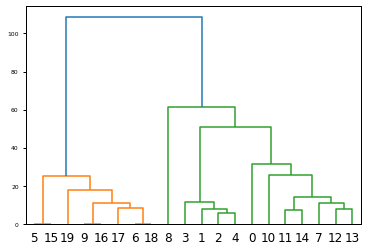

In [34]:
# cluster targets
import scipy
import scipy.cluster.hierarchy as sch
import scipy.spatial.distance as dist

tmp_df = -df.loc[motifs]
tmp_df.index = tmp_df.index.str.split('/').str[0]
d2 = dist.pdist(tmp_df)
D2 = dist.squareform(d2)
Y2 = sch.linkage(D2, method='average', metric='euclidean') ### array-clustering metric - 'average', 'single', 'centroid', 'complete'
Z2 = sch.dendrogram(Y2, no_plot=True)

/gpfs/data01/glasslab/home/h1bennet/.conda/envs/dataviz/lib/python3.7/site-packages/ipykernel_launcher.py:7: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  import sys


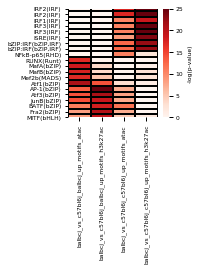

In [45]:
fig, ax = plt.subplots(figsize=(2,2))

tmp_df = -df.loc[motifs, :].iloc[:, [0,2,1,3]]
tmp_df.index = tmp_df.index.str.split('/').str[0]
d2 = dist.pdist(tmp_df)
D2 = dist.squareform(d2)
Y2 = sch.linkage(D2, method='average', metric='euclidean') ### array-clustering metric - 'average', 'single', 'centroid', 'complete'
Z2 = sch.dendrogram(Y2, no_plot=True)


sns.heatmap(tmp_df.iloc[Z2['leaves'], :],
            cmap='Reds',
            linewidth=1,
            linecolor='k',
            vmax=25,
            # annot=True,
            fmt='.1f',
            xticklabels=1,
            yticklabels=1,
            cbar_kws={'orientation':'vertical',
                      'pad':0.05,
                      'label':'-log(p-value)'})

plt.savefig('./c57bl6j_balbcj_pairwise_epigenetics/motif_enrichment_all_peaks_top5.pdf', bbox_inches='tight')


In [46]:
~tmp_df.index.duplicated()

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True,  True, False,
        True, False])

/gpfs/data01/glasslab/home/h1bennet/.conda/envs/dataviz/lib/python3.7/site-packages/ipykernel_launcher.py:8: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  


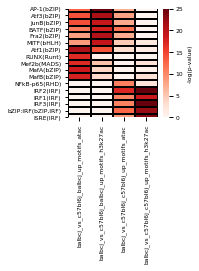

In [47]:
fig, ax = plt.subplots(figsize=(2,2))

tmp_df = -df.loc[motifs, :].iloc[:, [0,2,1,3]]
tmp_df.index = tmp_df.index.str.split('/').str[0]
tmp_df = tmp_df.loc[~tmp_df.index.duplicated(), :]
d2 = dist.pdist(tmp_df)
D2 = dist.squareform(d2)
Y2 = sch.linkage(D2, method='average', metric='euclidean') ### array-clustering metric - 'average', 'single', 'centroid', 'complete'
Z2 = sch.dendrogram(Y2, no_plot=True)


sns.heatmap(tmp_df.iloc[Z2['leaves'], :],
            cmap='Reds',
            linewidth=1,
            linecolor='k',
            vmax=25,
            # annot=True,
            fmt='.1f',
            xticklabels=1,
            yticklabels=1,
            cbar_kws={'orientation':'vertical',
                      'pad':0.05,
                      'label':'-log(p-value)'})

plt.savefig('./c57bl6j_balbcj_pairwise_epigenetics/motif_enrichment_all_peaks_top5_drop_dup.pdf', bbox_inches='tight')
